In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import pylab

# Modelado
# ==============================================================================
import scipy.stats as stats
from sklearn.impute import SimpleImputer


import re


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
# color settings:
# ==============================================================================
sns.set(rc={'axes.facecolor':"#EAEDED",
            "figure.facecolor":"#AED6F1",
            "grid.color":"#E0D3AF",
            "axes.edgecolor":"#424949",
            "axes.labelcolor":"#424949",
            "text.color":"#424949" # color for headlines and sub headlines
           }) 

In [3]:
url_train = "https://github.com/PabloJRW/titanic-classifier/raw/main/train.csv"
url_test = "https://github.com/PabloJRW/titanic-classifier/raw/main/test.csv"
df_train = pd.read_csv(url_train)
df_test = pd.read_csv(url_test)

# <b>EDA (Análisis Exploratorio de Datos) 

In [4]:
df_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Eliminción de variables irrelevantes
df_train.drop(['PassengerId','Name'], axis=1, inplace=True)
df_test.drop(['PassengerId','Name'], axis=1, inplace=True)
# Renombrado de variables en datos de entrenamiento
df_train.columns = ["vida", "clase", "sexo", "edad", "sibsp", "parch", "ticket", "tarifa", "cabina", "puerto"]
# Renombrado de variables en datos de prueba
df_test.columns = ["clase", "sexo", "edad", "sibsp", "parch", "ticket", "tarifa", "cabina", "puerto"]

In [6]:
# Tipo de cada columna
# ==============================================================================
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   vida    891 non-null    int64  
 1   clase   891 non-null    int64  
 2   sexo    891 non-null    object 
 3   edad    714 non-null    float64
 4   sibsp   891 non-null    int64  
 5   parch   891 non-null    int64  
 6   ticket  891 non-null    object 
 7   tarifa  891 non-null    float64
 8   cabina  204 non-null    object 
 9   puerto  889 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 69.7+ KB


In [7]:
# Dimensiones del dataset
# ==============================================================================
df_train.shape

(891, 10)

In [8]:
# Número de datos ausentes por variable
# ==============================================================================
df_train.isna().sum().sort_values(ascending=False)

cabina    687
edad      177
puerto      2
vida        0
clase       0
sexo        0
sibsp       0
parch       0
ticket      0
tarifa      0
dtype: int64

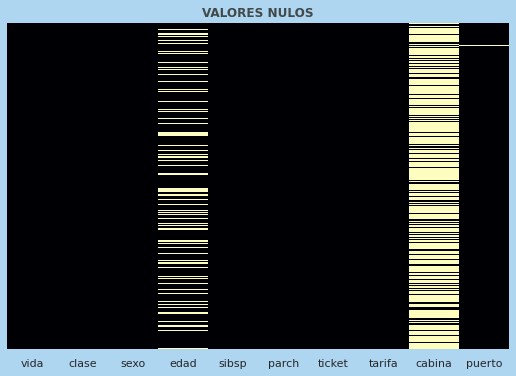

In [9]:
# Visualización de variables con valores faltantes
plt.figure(figsize=(9,6))
plt.title('VALORES NULOS', fontweight='bold')
sns.heatmap(df_train.isnull(), yticklabels=False, cbar=False, cmap='magma')
plt.show()

In [11]:
# La varaible cabina contiene gran cantida de valores faltantes
# por lo que la elimino.
df_train.drop('cabina', axis=1, inplace=True)
df_test.drop('cabina', axis=1, inplace=True)

# Copia de los datasets
train = df_train.copy()
test = df_test.copy()

## <b>Variable Respuesta 

La variable respuesta para el modelo a desarrollar es <b>'vida'</b>, la cual nos indica si un pasajero sobrevivió o no
al hundimiento del Titanic. <b>0</b> = Falleció, <b>1</b> = Sobrevivió.

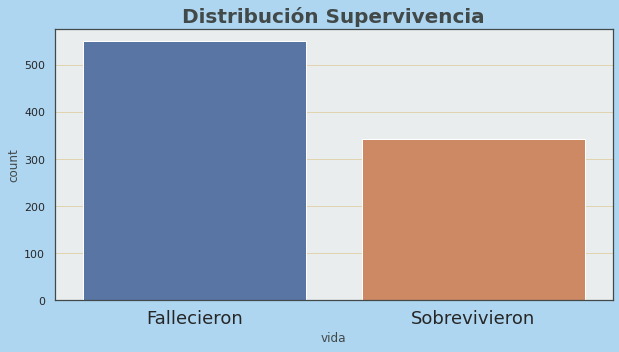

In [12]:
# Distribución de la variable objetivo
fig, ax = plt.subplots(figsize=(10, 5))
plt.title('Distribución Supervivencia', fontweight='bold', fontsize=20)
sns.countplot(x=train['vida'], ax=ax)
ax.set_xticklabels(('Fallecieron', 'Sobrevivieron'), fontsize=18)
plt.show()

In [13]:
# Cuál fue el porcentaje de sobrevivientes?
print(f"Porcentaje de supervivientes: {round(len(train[train['vida']==1]) / len(train) * 100, 1) }%")

Porcentaje de supervivientes: 38.4%


<b>📝 Note:</b> El 38.4% de los pasajeros que viajaron abordo del Titanic sobrevivieron, en contraparte, falleció el 61.6%.

## <b>VARIABLES NUMÉRICAS

## *****************************************************************************

In [14]:
# Variables numéricas
# ==============================================================================
train.select_dtypes(include=["float64", "int"]).describe()

,vida,clase,edad,sibsp,parch,tarifa
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


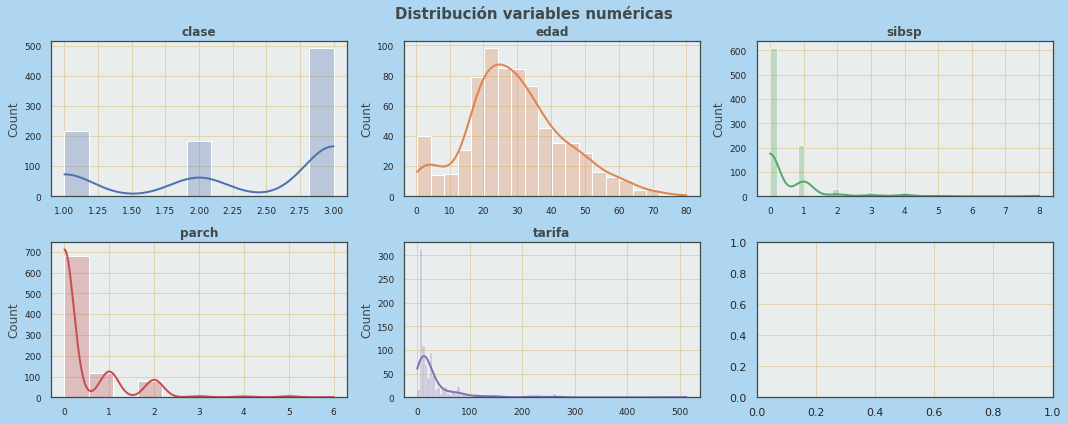

In [15]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 6))
axes = axes.flat
columnas_numeric = train.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop('vida')

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = train,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 12, fontweight = "bold")
    axes[i].tick_params(labelsize = 9)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 15, fontweight = "bold");

Aunque algunas variables contienen valores numéricos, realmente son variables categóricas. Además procedo a eliminar la variable <b>"id"</b>, la cual hace referencia al número de indentificación de los pasajeros.

### <b> Edad

Esta variable contiene 177 observaciones faltantes

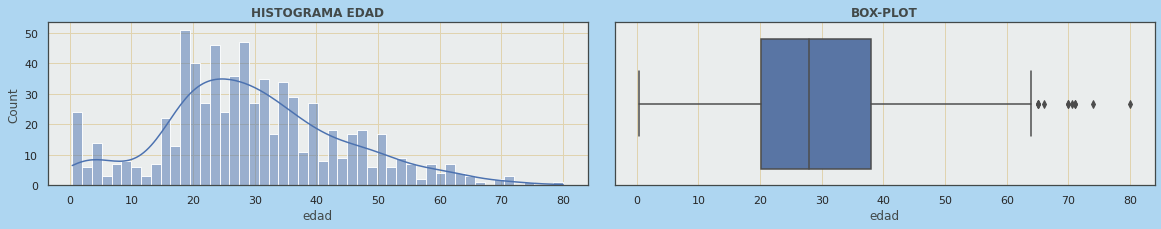

In [16]:
# Gráficas de distribución para la variable edad
# ==============================================================================
fig = plt.figure(figsize=(30,3))
gs = fig.add_gridspec(1,3)

ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])

ax0.set_title("HISTOGRAMA EDAD", fontweight='bold')
ax1.set_title("BOX-PLOT", fontweight='bold')

sns.histplot(x=train.edad , bins=50, kde=True, ax=ax0)
sns.boxplot(x=train.edad, ax=ax1)
fig.subplots_adjust(wspace=0.05)
plt.show()

In [17]:
# Prueba de mormalidad Shapiro-Wilk
# ==============================================================================
mask = train['edad'].dropna() # 'edad' sin incluir los valores faltantes

stat, p = stats.shapiro(mask)
print('Statistics= %.3f, p-value= %.3f' %(stat, p))
alpha = 0.05
if p > alpha:
    print("La muestra parece ser Gaussiana (distribución normal)")
else:
    print("La muestra parece ser no Gaussiana (distribución no normal)")

Statistics= 0.981, p-value= 0.000
La muestra parece ser no Gaussiana (distribución no normal)


<div style="color:#9A7D0A;
           display:fill;
           padding: 5px;
           border-radius:10px;
           border-style: solid;
           border-color: #F9E79F;
           background-color:#FCF3CF;
           font-size:15px;
           font-family: Didot;
           letter-spacing:0.5px">
    <b>📝 Note:</b> La distribución de la variable <b>edad</b> mediante el histograma y gráfico de cajas muestra cierto sesgo positivo, sin embargo, el test de normalidad (Shapiro-Wilk), nos indica que efectivamente esta variable no se distribuye de manera Gaussiana.
</div>

<div style="color:#9A7D0A;
           display:fill;
           padding: 5px;
           border-radius:10px;
           border-style: solid;
           border-color: #F9E79F;
           background-color:#FCF3CF;
           font-size:15px;
           font-family: Didot;
           letter-spacing:0.5px">
    <b>📝 Note:</b> Esta variable contiene outliers.
</div>

### <b>Tarifa

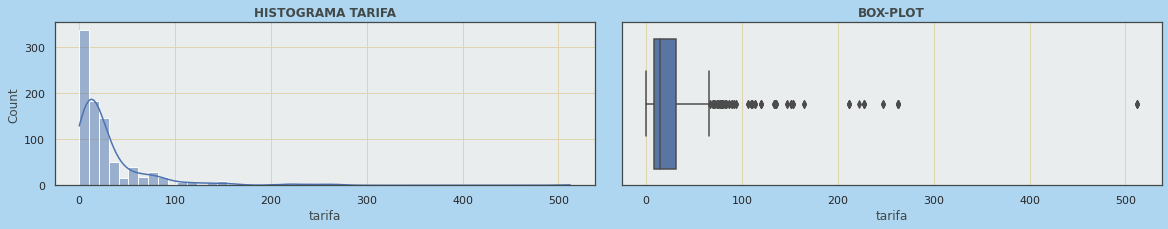

In [18]:
# Gráficas de distribución para la variable tarifa
# ==============================================================================
fig = plt.figure(figsize=(30,3))
gs = fig.add_gridspec(1,3)

ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])

ax0.set_title("HISTOGRAMA TARIFA", fontweight='bold')
ax1.set_title("BOX-PLOT", fontweight='bold')

sns.histplot(x=train.tarifa , bins=50, kde=True, ax=ax0)
sns.boxplot(x=train.tarifa, ax=ax1)
fig.subplots_adjust(wspace=0.05)
plt.show()

## <b>VARIABLES CUALITATIVAS

## *****************************************************************************

In [60]:
train = df_train.copy()
test = df_test.copy()

In [61]:
# Transformando variables a categóricas
for col in ['parch','clase','sibsp']:
    train[col] = train[col].astype('object')

In [62]:
# Variables cualitativas (tipo object)
# ==============================================================================
train.select_dtypes(include=['object']).describe()

,clase,sexo,sibsp,parch,ticket,puerto
count,891,891,891,891,891,889
unique,3,2,7,7,681,3
top,3,male,0,0,347082,S
freq,491,577,608,678,7,644


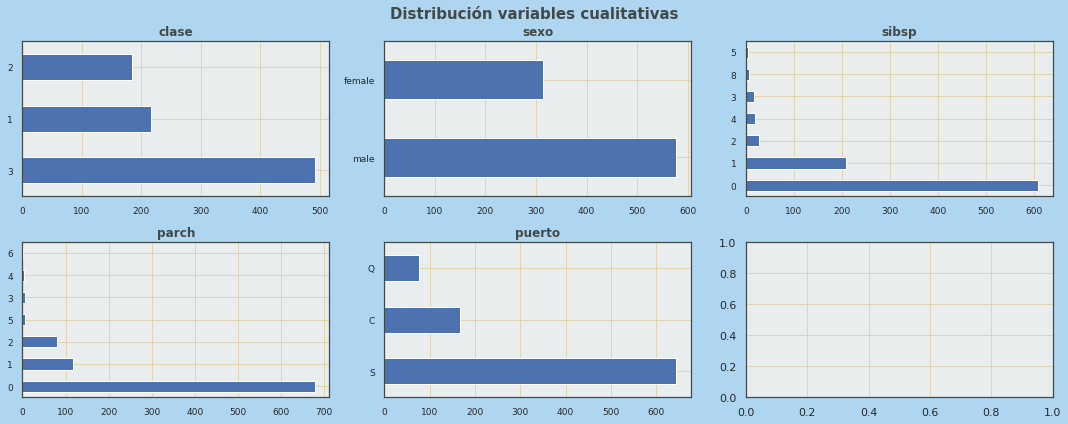

In [63]:
# Gráfico para cada variable cualitativa
# ==============================================================================

mask = train.drop(['ticket'], axis=1)

# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 6))
axes = axes.flat
columnas_object = mask.select_dtypes(include=['object']).columns

for i, colum in enumerate(columnas_object):
    mask[colum].value_counts().plot.barh(ax = axes[i])
    axes[i].set_title(colum, fontsize = 12, fontweight = "bold")
    axes[i].tick_params(labelsize = 9)
    axes[i].set_xlabel("")
 
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución variables cualitativas',
             fontsize = 15, fontweight = "bold");

### <b>Parch

Esta variable contiene observaciones que van desde 0 hasta el 6. En la que el valor 0: representa a los pasajeros que viajaron sin acompañantes; 1: acompañados por una persona; 2: acompañados por dos personas, y así sucesivamente.

In [71]:
# Cantidad por acompañantes en parch
train.parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: parch, dtype: int64

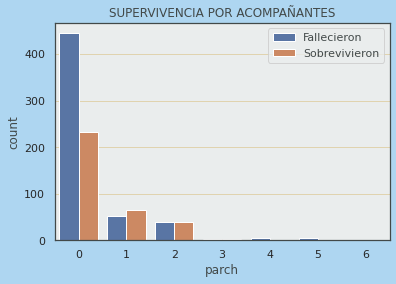

In [70]:
# Gráfica de supervivencia por acompañantes
plt.title("SUPERVIVENCIA POR ACOMPAÑANTES")
sns.countplot(x='parch', hue='vida', data=train)
plt.legend(['Fallecieron', 'Sobrevivieron'], loc='upper right')
plt.show()

<div style="color:#9A7D0A;
           display:fill;
           padding: 5px;
           border-radius:10px;
           border-style: solid;
           border-color: #F9E79F;
           background-color:#FCF3CF;
           font-size:15px;
           font-family: Didot;
           letter-spacing:0.5px">
<b>📝 Note:</b> Hay muy pocas observaciones de pasajeros que no viajaron solos.
</div>

<div style="color:#21618C;
           display:fill;
           padding: 5px;
           border-radius:10px;
           border-style: solid;
           border-color: #AED6F1;
           background-color:#D6EAF8;
           font-size:15px;
           font-family: Didot;
           letter-spacing:0.5px">
<b>💡 Idea:</b> Convertir las observaciones en valores binarios. Pasajeros que viajaron solos y pasajeros acompañados.
</div>

## <b> Clase



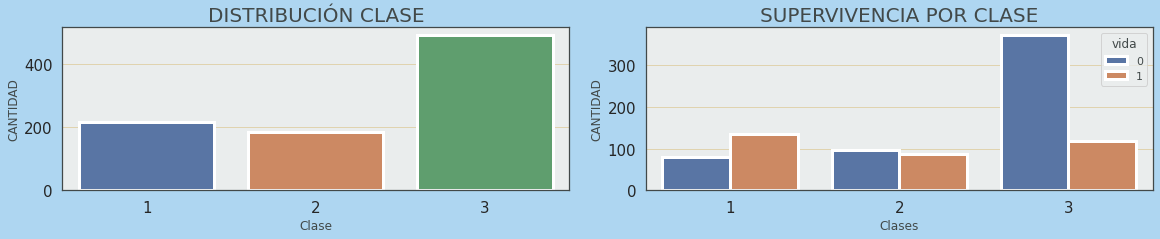

In [83]:
# Visualización de distribución de clases
fig = plt.figure(figsize=(30,3))

# add grid to figure
gs = fig.add_gridspec(1,3)

# fill grid with subplots
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])

# adjust subheadline fontsize
ax0.set_title("DISTRIBUCIÓN CLASE", fontsize=20)
ax1.set_title("SUPERVIVENCIA POR CLASE", fontsize=20)

# adjust lable fontsize
ax0.tick_params(labelsize=15)
ax1.tick_params(labelsize=15)

# plot data into subplots 
sns.countplot(x="clase",data=train, ax=ax0, linewidth = 3).set(xlabel="Clase", ylabel="CANTIDAD")
sns.countplot(x="clase",data=train, ax=ax1, linewidth = 3, hue="vida").set(xlabel="Clases",ylabel="CANTIDAD")
fig.subplots_adjust(wspace=0.15)
plt.show()

<b>📝 Note:</b> La mayoría de los pasajeros abordo viajaron en tercera clase, seguido por los de primera clase y segunda clase.



<b>📝 Note:</b> La primera clase fue la única que registró una razón de sobrevivientes mayor que los fallecidos, sin embargo, es notable la gran proporción de fallecidos que viajaron en tercera clase. Esta parece ser una variable de peso para inferir si un pasajero abordo sebrevivió o no.  


In [ ]:
train['Pclass'].where(train['Survived']==1).value_counts()

## <b>"Fare" (Tarifa)

In [ ]:
plt.figure(figsize=(9,6))
plt.title("DISTRIBUCIÓN TARIFA", fontweight='bold')
sns.histplot(train['tarifa'], bins=50, kde=True)
plt.show()

<b>📝 Note:</b>

### <b>Tarifa por clase

In [ ]:
# build figure
fig = plt.figure(figsize=(25.5,2))

gs = fig.add_gridspec(1,3)

# fill grid with subplots
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])

# adjust subheadline fontsize
ax0.set_title('Pclass = 1', fontsize=20)
ax1.set_title('Pclass = 2', fontsize=20)
ax2.set_title('Pclass = 3', fontsize=20)

# adjust lable fontsize
ax0.tick_params(labelsize=15)
ax1.tick_params(labelsize=15)
ax2.tick_params(labelsize=15)

# plot data into subplots 
sns.boxplot(x="tarifa",data=train[train['clase']==1], orient="h", ax=ax0, linewidth = 3, hue="vida").set(xlabel="tarifa")
sns.boxplot(x="tarifa",data=train[train['clase']==2], orient="h", ax=ax1, linewidth = 3, hue="vida").set(xlabel="tarifa")
sns.boxplot(x="tarifa",data=train[train['clase']==3], orient="h", ax=ax2, linewidth = 3, hue="vida").set(xlabel="tarifa")

# add headline
fig.subplots_adjust(top=0.6)
fig.suptitle('Distribución de tarifa por clase', fontsize="28");

<b>📝 Note:</b>La distribución de tarifas para los pasajeros en primera clase es mayor que en segunda y tercera clase, por lo que, queda claro que estos pagaron un tarifa más alta por viajar en primera clase, sin embargo, podemos ver que pasajeros en primera clase pagaron poco o nada.

In [ ]:
def iqr_outliers(df):
    """Utiliza la regla del rango intercuartílico para detectar outliers en tarifa ('Fare')."""
    """Retorna los indices de las entradas con outliers en tarifa ('Fare') por clase ('Pclass')."""
    
    # Tarifas por clase
    first_class = df[df['Pclass']==1]['Fare']  # Tarifas de los que viajaron en primera clase
    second_class = df[df['Pclass']==2]['Fare'] # Tarifas de los que viajaron en segunda clase
    third_class = df[df['Pclass']==3]['Fare']  # Tarifas de los que viajaron en tercera clase
    
    # Busca el valor desde el cual inicia los outliers en primera clase
    sorted(first_class)
    Q1_1class, Q3_1class = np.percentile(first_class , [25,75]) # Q1, Q3
    IQR_1class = Q3_1class - Q1_1class   # Rango Intercuartílico
    c1_bound = Q3_1class + (1.5 * IQR_1class)   # outlier inicial primera clase
    
    # Busca el valor desde el cual inicia los outliers en segunda clase
    sorted(second_class)
    Q1_2class,Q3_2class = np.percentile(second_class , [25,75])   #Q, Q3
    IQR_2class = Q3_2class - Q1_2class   # Rango Intercuartílico
    c2_bound = Q3_2class + (1.5 * IQR_2class)   # outlier inicial segunda clase
   
    # Busca el valor desde el cual inicia los outliers en tercera clase
    sorted(third_class)
    Q1_3class,Q3_3class = np.percentile(third_class , [25,75])   # Q1, Q3
    IQR_3class = Q3_3class - Q1_3class   # Rango Intercuartílico
    c3_bound = Q3_3class + (1.5 * IQR_3class)   # outlier inicial tercera clase
   
    # Outliers en primera clase
    c1_outliers = train[(train['Pclass']==1) & (train['Fare']>=c1_bound)]
    # Outliers en segunda clase
    c2_outliers = train[(train['Pclass']==2) & (train['Fare']>=c2_bound)]
    # Outliers en tercera clase
    c3_outliers = train[(train['Pclass']==3) & (train['Fare']>=c3_bound)]

    return c1_outliers.index, c2_outliers.index, c3_outliers.index

## <b>"Sex" (Sexo)

In [ ]:
# Visualización de distribución de sexo
# build figure
fig = plt.figure(figsize=(27,6))

# add grid to figure
gs = fig.add_gridspec(1,3)

# fill grid with subplots
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])

# adjust subheadline fontsize
ax0.set_title("DISTRIBUCIÓN SEXO", fontsize=20)
ax1.set_title("SEXO / SUPERVIVENCIA", fontsize=20)

# adjust lable fontsize
ax0.tick_params(labelsize=15)
ax1.tick_params(labelsize=15)

# plot data into subplots 
sns.countplot(x="Sex",data=train, ax=ax0, linewidth = 3).set(xlabel="SEXO", ylabel="CANTIDAD DE PASAJEROS")
sns.countplot(x="Sex",data=train, ax=ax1, linewidth = 3, hue="Survived").set(xlabel="SEXO", ylabel="CANTIDAD DE PASAJEROS")
plt.legend(["fallecieron", "sobrevivieron"])
fig.subplots_adjust(wspace=0.25)
plt.show()

In [ ]:
# Cantidad de pasajeros por sexo
pxs = train['Sex'].value_counts() # pasajeros por sexo
ppxs = ((pxs / len(train)) * 100).round(2) # porcentaje pasajeros por sexo
print("El conjunto de datos de entrenamiento cuenta con "+str(len(train))+" instancias (pasajeros), de los cuales:")
print(str(pxs[0])+" es decir, el "+str(ppxs[0])+ " eran mujeres.")
print(str(pxs[1])+" es decir, el "+str(ppxs[1])+ " eran hombres.")


<b>📝 Note:</b> De manera gráfica podemos concluir que un gran porcenaje de pasajeros fallecidos fueron hombres.


In [ ]:
# Porcentaje de supervivientes por sexo.
hombres_df = train[train['Sex']=='male']
mujeres_df = train[train['Sex']=='female']

print('El '+ str(round(len(hombres_df[hombres_df['Survived']==1])*100/len(hombres_df))) +'% de los hombres sobrevivió.')
print('El '+ str(round(len(mujeres_df[mujeres_df['Survived']==1])*100/len(mujeres_df))) +'% de los mujeres sobrevivió.')


<b>💡 Idea:</b> Hasta el momento, al parecer las mujeres en primera clase tuvieron una alta probabilidad de sobrevivir.

In [ ]:
# Supervivencia entre las variables clase y sexo.
fig = plt.figure(figsize=(27,6))
gs = fig.add_gridspec(1,3)

ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])

ax0.set_title('MUJERES POR CLASE')
ax1.set_title('HOMBRES POR CLASE')

#plt.suptitle('SUPERVIVENCIA VS SEXO/CLASE', fontweight='bold')
sns.countplot(data=train[train['Sex']=='female'], x='Survived', hue='Pclass', ax=ax0)
ax0.set_xticklabels(["fallecieron", "sobrevivieron"])
sns.countplot(data=train[train['Sex']=='male'], x='Survived', hue='Pclass', ax=ax1)
ax1.set_xticklabels(["fallecieron", "sobrevivieron"])
plt.subplots_adjust(top = 0.9)
plt.show()

In [ ]:
# Porcentaje de mujeres supervivientes por clase
mujeres_sup = mujeres_df[mujeres_df['Survived']==1]
for i in [1,2,3]:
  mujeres_sup_por = len(mujeres_sup[mujeres_sup['Pclass']==i]) / len(mujeres_df[mujeres_df['Pclass']==i]) * 100
  print("El "+ str(round(mujeres_sup_por)) +"% de las mujeres en "+str(i)+" clase sobrevivió.")

<b>📝 Note:</b> Efectivamente, las mujeres que viajaron en primera clase tuvieron una alta probabilidad de sobrevivir, pues sobrevivió el 97% de ellas. No muy distinto, el 92% de mujeres en segunda clase sobrevivió. 



## <b>"Age" (Edad)

In [ ]:
def normality_test(feature):
    from scipy.stats import shapiro
    stat, p = shapiro(feature)
    alpha = 0.05
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')
normality_test(train.Age)

In [ ]:
from scipy.stats import spearmanr

mask = train[['Age', 'Survived']].dropna()
edad =mask['Age']; sup = mask['Survived']
coef, p = spearmanr(edad, sup)
print(coef, p)

In [ ]:
# 
fig = plt.figure(figsize=(12,6))
plt.title('MEDIA DE EDAD POR CLASE', fontsize="20")
sns.boxplot(x='Age', y='Pclass', hue='Sex', orient='h', data=train)
fig.subplots_adjust(top=0.6)
plt.show()

<div style="color:#21618C;
           display:fill;
           padding: 5px;
           border-radius:10px;
           border-style: solid;
           border-color: #AED6F1;
           background-color:#D6EAF8;
           font-size:15px;
           font-family: Didot;
           letter-spacing:0.5px">
<b>💡 Idea:</b> La media de edad por clase podria ser el mejor valor para realizar imputacion de los valores nulos en 'Age'.

## <b>"Sibsp" (Acompañantes)

In [ ]:
fig = plt.figure(figsize=(15, 5))
gs = fig.add_gridspec(1, 2)

ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])

plt.suptitle('SibSp vs. Parch', fontweight='bold', fontsize=20)
plt.subplots_adjust(top=0.9, wspace=.25)
ax0.set_title('Distribución Sibsp')
ax1.set_title('Distribución Parch')

sns.countplot(x='SibSp', data=train, ax=ax0)
sns.countplot(x='Parch', data=train, ax=ax1)
plt.show()

### Acompañados por herman@s y espos@s

In [ ]:
# Distribucion de pasajeros acompañados(Herman@s-Espos@)
fig = plt.figure(figsize=(15, 5))
gs = fig.add_gridspec(1, 2)

ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])

plt.suptitle('Acompañados SibSp', fontweight='bold', fontsize=20)
plt.subplots_adjust(top=0.9, wspace=.25)
ax0.set_title('Distribución')
ax1.set_title('Sibsp / Supervivencia')

sns.countplot(x='SibSp', data=train, ax=ax0)
sns.countplot(x='SibSp', hue='Survived', data=train, ax=ax1)
plt.show()

In [ ]:
super_sibsp =[]
for x in train['SibSp'].unique():
  frecuencia_sibsp = len(train[train['SibSp']==x])
  sup = frecuencia_sibsp - (len(train.loc[(train['SibSp']==x) & (train['Survived']==1)]))
  per_sibsp = round((frecuencia_sibsp / len(train['SibSp']) * 100), 2)
  per_sup_sibsp = round((len(train.loc[(train['SibSp']==x) & (train['Survived']==1)]) / frecuencia_sibsp * 100), 2)
  super_sibsp.append({'# Acompañantes':x, '# Sobrevivientes':sup, '% Acompañantes':per_sibsp, '% Sobrevivientes':per_sup_sibsp})

super_sibsp.sort(key=lambda k: k['% Sobrevivientes'], reverse=True)
super_sibsp = pd.DataFrame(super_sibsp)
for i in range(len(super_sibsp)):
  surv = super_sibsp.loc[i, '# Sobrevivientes']
  cant = super_sibsp.loc[i, '# Acompañantes']
  per_sibsp = super_sibsp.loc[i, '% Acompañantes']
  perc = super_sibsp.loc[i, '% Sobrevivientes']
pd.DataFrame(super_sibsp)

### Acompañados por padres e hij@s

In [ ]:
# Distribucion de pasajeros acompañados(Padres-Hijos)
fig = plt.figure(figsize=(15, 5))
gs = fig.add_gridspec(1, 2)

ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])

plt.suptitle('Acompañados Parch', fontweight='bold', fontsize=20)
plt.subplots_adjust(top=0.9, wspace=.25)
ax0.set_title('Distribución')
ax1.set_title('Parch / Supervivencia')

sns.countplot(x='parch', data=train, ax=ax0)
sns.countplot(x='parch', hue='vida', data=train, ax=ax1)
plt.show()

In [ ]:
super_parch =[]
for x in train['Parch'].unique():
  frecuencia_parch = len(train[train['Parch']==x])
  sup = frecuencia_parch - (len(train.loc[(train['Parch']==x) & (train['Survived']==1)]))
  per_parch = round((frecuencia_parch / len(train['Parch']) * 100), 2)
  per_sup_parch = round((len(train.loc[(train['Parch']==x) & (train['Survived']==1)]) / frecuencia_parch * 100), 2)
  super_parch.append({'cant':x, 'sup':sup, 'porcentaje_sup':per_sup_parch})
  
super_parch.sort(key=lambda k: k['porcentaje_sup'], reverse=True)
super_parch = pd.DataFrame(super_parch)
for i in range(len(super_parch)):
  cant = super_parch.loc[i, 'cant']
  surv = super_parch.loc[i, 'sup']
  perc = super_parch.loc[i, 'porcentaje_sup']
  print(str(surv)+" pasajeros, es decir, el "+str(perc)+"% de los que viajaron acompañados por "+str(cant)+" personas sobrevivieron.")

# <b>Correlations<b>

In [ ]:
# Correlaciones entre todas las variables numericas contra supervivencia
corr_matrix = train.corr(method='spearman').round(2)
corr_matrix['Survived'].sort_values(ascending=False)

In [ ]:
sns.heatmap(corr_matrix, annot=True)
plt.show()

# <b>PREPARE DATA

In [ ]:
X_train = train.drop(['PassengerId', 'Survived', 'Ticket', 'Cabin', 'PassengerId', 'Fare', 'Name'], axis='columns')
y_train = train.Survived

In [ ]:
num_features = X_train.Age
cat_features = X_train.drop('Age', axis=1).astype('category')

### Preprocesador

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.experimental import enable_iterative_imputer 
from sklearn.linear_model import BayesianRidge
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier


# numerical transformer pipeline (only contains 'Age')
num_transformer = Pipeline([ 
    ("imputer", SimpleImputer(strategy='median')),
    ("scaler", StandardScaler()),
                           ])

# categorical transformer pipeline
cat_transformer = Pipeline([ 
    ('cat_imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
                            ])

final_pipe = ColumnTransformer([
    ('num_transfomer', num_transformer, num_features),
    ('cat_transformer', cat_transformer, cat_features),
                                ],remainder='passthrough')

X_prepared =final_pipe.fit_transform(X_train)

### SELECT A MODEL

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


models = {'svc': SVC(), 
          'sgd': SGDClassifier(), 
          'logistic': LogisticRegression(),
          'decision_tree': DecisionTreeClassifier(), 
          'random_forest': RandomForestClassifier(),
          'knn': KNeighborsClassifier()}

n_models = len(models)
scores=[]
for name, model in models.items():
    y_train_pred = cross_val_predict(model, X_prepared, y_train, cv=5)
    precision = np.mean(precision_score(y_train, y_train_pred)).round(2)
    recall = np.mean(recall_score(y_train, y_train_pred)).round(2)
    f1 = np.mean(f1_score(y_train, y_train_pred)).round(2)

    model_scores = np.array([name, precision, recall, f1])
    scores.append(np.array(model_scores))
    
      
scores_df = pd.DataFrame(scores, columns=['Model', 'Precision', 'Recall', 'F1']); scores_df.set_index('Model', inplace=True)
scores_df.sort_values(by='F1', ascending=False)

In [ ]:
from sklearn.metrics import classification_report

logistic_clf = LogisticRegression(random_state=42)
y_pred = cross_val_predict(logistic_clf, X_prepared, y_train)
print(classification_report(y_train, y_pred))

In [ ]:
from sklearn.metrics import precision_recall_curve

logistic_clf = LogisticRegression(random_state=42)
logistic_clf.fit(X_prepared, y_train)
y_scores = cross_val_predict(logistic_clf, X_prepared, y_train, cv=5, method='decision_function', n_jobs=-1)
threshold = 0.5
y_with_thres = (y_scores > threshold)
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)


def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    
#plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds =roc_curve(y_train, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

# Puntaje del area bajo la curva
roc_auc_score(y_train, y_pred)

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold

# Busqueda de los mejores hiperparametros para el modelo(SVM)
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
param_grid = [{'solver':['newton-cg', 'lbfgs', 'liblinear'], 'penalty':['l1', 'l2'],
              'C':[30, 25, 20, 15, 10, 5, 1.0]}]
              
grid_search = GridSearchCV(logistic_clf, param_grid, cv=kfold, scoring='accuracy')

In [ ]:
grid_search.fit(X_prepared, y_train)
grid_search.best_params_

In [ ]:
final_model = grid_search.best_estimator_
final_model.score(X_prepared, y_train)

In [ ]:
test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [ ]:
test_prepared = final_pipe.transform(test)

In [ ]:
predictions = final_model.predict(test_prepared)
test['Survived'] = predictions

In [ ]:
preds = test[['PassengerId', 'Survived']]
#preds = preds.set_index('PassengerId')
preds.to_csv('submission.csv',index=False)

In [ ]:
preds